# TP1 - Regresión
Notebook inicial para el trabajo práctico.

In [77]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import holidays

In [78]:
# Carga de datos y visualización inicial
file_path= 'uber_fares.csv'
df = pd.read_csv(file_path)
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


A modificar


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [79]:
#Análisis inicial
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [80]:
# por que lo hicimos??

df.apply(pd.unique)

key                  [24238194, 27835199, 44984355, 25894730, 17610...
date                 [2015-05-07 19:52:06.0000003, 2009-07-17 20:04...
fare_amount          [7.5, 7.7, 12.9, 5.3, 16.0, 4.9, 24.5, 2.5, 9....
pickup_datetime      [2015-05-07 19:52:06 UTC, 2009-07-17 20:04:56 ...
pickup_longitude     [-73.99981689453125, -73.994355, -74.005043, -...
pickup_latitude      [40.73835372924805, 40.728225, 40.74077, 40.79...
dropoff_longitude    [-73.99951171875, -73.99471, -73.962565, -73.9...
dropoff_latitude     [40.72321701049805, 40.750325, 40.772647, 40.8...
passenger_count                             [1, 3, 5, 2, 4, 6, 0, 208]
dtype: object

In [81]:
df.nunique()

key                  200000
date                 200000
fare_amount            1244
pickup_datetime      196629
pickup_longitude      71066
pickup_latitude       83835
dropoff_longitude     76894
dropoff_latitude      90585
passenger_count           8
dtype: int64

In [82]:
# Eliminamos la columna 'key' porque no aporta al análisis
df = df.drop(columns=['key'])

In [83]:
# Falta comprobacion

# Sopechamos que la columna 'date' redunda datos con 'pickup_datetime', lo comprobamos y prodecemos a eliminarla
df = df.drop(columns=['date'])

In [84]:
df['passenger_count'].value_counts()

passenger_count
1      138425
2       29428
5       14009
3        8881
4        4276
6        4271
0         709
208         1
Name: count, dtype: int64

In [85]:
# Decidimos crear variables de distancia en base a las coordenadas de latitud y longitud, ya que consideramos que deberia estar 
# correlacionada con el valor del viaje (fare_amount), utilizamos dos metodos: Manhattan y Haversine

# Distancia Manhattan en km
def distancia_absoluta(lat1, lon1, lat2, lon2):
    """
    Calcula la suma de las diferencias absolutas entre latitud y longitud.
    Es decir, la distancia Manhattan en coordenadas.
    """
    return np.abs(lat2 - lat1) + np.abs(lon2 - lon1)

df["distancia_recorrida"] = distancia_absoluta(
    df["pickup_latitude"], df["pickup_longitude"],
    df["dropoff_latitude"], df["dropoff_longitude"]
)

df["distancia_recorrida_km"] = df["distancia_recorrida"] * 111

# Distancia haversine (en km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

df['dist_haversine'] = haversine(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude'])

In [86]:
# Creamos una variable que represente el día, para ello decidimos dividir los dias de la semana en laborables (de lunes a viernes) y no laborables 
# (sabado, domingo y feriados). Usamos la libreria Holidays para definir los feriados de New York
feriados = holidays.US(state='NY')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['es_feriado'] = df['pickup_datetime'].dt.date.apply(lambda x: 1 if x in feriados else 0)
df['es_fin_de_semana'] = df['pickup_datetime'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
df['es_no_laborable'] = ((df['es_fin_de_semana'] == 1) | (df['es_feriado'] == 1)).astype(int)
df = df.drop(columns=['es_feriado', 'es_fin_de_semana'])

df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine,es_no_laborable
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.015442,1.714050,1.683323,0
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,0.022455,2.492505,2.457590,0
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,0.074355,8.253405,5.036377,0
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,0.023313,2.587743,1.661683,0
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,0.065221,7.239531,4.475450,0
...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,0.001447,0.160617,0.112210,1
199996,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,0.024733,2.745363,1.875050,0
199997,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,0.190959,21.196449,12.850319,0
199998,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,0.043945,4.877930,3.539715,0


In [87]:
# Creamos la variable "hora del día" extrayendo la hora (de 0 a 23) del campo pickup_datetime.
# Luego, transformamos esta variable en dos nuevas columnas usando funciones seno y coseno, lo que permite representar la naturaleza
# cíclica de las horas en el día.
df['hora_del_dia'] = df['pickup_datetime'].dt.hour
df['hora_sin'] = np.sin(2 * np.pi * df['hora_del_dia'] / 24)
df['hora_cos'] = np.cos(2 * np.pi * df['hora_del_dia'] / 24)
df = df.drop(columns=['hora_del_dia'])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine,es_no_laborable,hora_sin,hora_cos
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.015442,1.714050,1.683323,0,-0.965926,0.258819
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,0.022455,2.492505,2.457590,0,-0.866025,0.500000
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,0.074355,8.253405,5.036377,0,-0.707107,0.707107
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,0.023313,2.587743,1.661683,0,0.866025,-0.500000
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,0.065221,7.239531,4.475450,0,-0.965926,-0.258819


In [88]:
# Creemos que puede llegar a ser relevante si el viaje se realiza en la primera o segunda mitad del mes, por lo que creamos dos variables dummies
# representando la quincena
df['1era_mitad_mes'] = (df['pickup_datetime'].dt.day < 15).astype(int)
df['2da_mitad_mes'] = (df['pickup_datetime'].dt.day >= 15).astype(int)
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine,es_no_laborable,hora_sin,hora_cos,1era_mitad_mes,2da_mitad_mes
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.015442,1.714050,1.683323,0,-0.965926,0.258819,1,0
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,0.022455,2.492505,2.457590,0,-0.866025,0.500000,0,1
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,0.074355,8.253405,5.036377,0,-0.707107,0.707107,0,1
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,0.023313,2.587743,1.661683,0,0.866025,-0.500000,0,1
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,0.065221,7.239531,4.475450,0,-0.965926,-0.258819,0,1


In [89]:
# Creamos las variables dummies de estación del año (invierno, primavera, verano, otoño), creeemos que puede llegar a ser relevante para el valor del viaje
# ya que es probable que en estaciones donde hace más frío (invierno) o más calor (verano) la demanda y el valor del viaje se vean afectados.

df['pickup_datetime'] = df['pickup_datetime'].dt.tz_localize(None)

def estacion_astronomica(fecha):
    y = fecha.year
    if fecha >= pd.Timestamp(y, 12, 21) or fecha < pd.Timestamp(y, 3, 20):
        return 'invierno'
    elif fecha >= pd.Timestamp(y, 3, 20) and fecha < pd.Timestamp(y, 6, 21):
        return 'primavera'
    elif fecha >= pd.Timestamp(y, 6, 21) and fecha < pd.Timestamp(y, 9, 22):
        return 'verano'
    else:
        return 'otoño'

df['estacion'] = df['pickup_datetime'].apply(estacion_astronomica)

dummies = pd.get_dummies(df['estacion'], prefix='', prefix_sep='')
for estacion in ['invierno', 'primavera', 'verano', 'otoño']:
    df[estacion] = dummies.get(estacion, pd.Series(0, index=df.index)).astype(int)
df = df.drop(columns=['estacion'])

df[['pickup_datetime', 'invierno', 'primavera', 'verano', 'otoño']].head()

,pickup_datetime,invierno,primavera,verano,otoño
0,2015-05-07 19:52:06,0,1,0,0
1,2009-07-17 20:04:56,0,0,1,0
2,2009-08-24 21:45:00,0,0,1,0
3,2009-06-26 08:22:21,0,0,1,0
4,2014-08-28 17:47:00,0,0,1,0


In [90]:
# Dividimos passenger_count en 3 categorias: delivery (0 pasajeros), standard (1 a 4 pasajeros) y xl (más de 4 pasajeros).

df['delivery'] = (df['passenger_count'] == 0).astype(int)
df['standard'] = df['passenger_count'].between(1, 4).astype(int)
df['xl'] = (df['passenger_count'] > 4).astype(int)
df = df.drop(columns=['passenger_count'])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distancia_recorrida,distancia_recorrida_km,dist_haversine,es_no_laborable,...,hora_cos,1era_mitad_mes,2da_mitad_mes,invierno,primavera,verano,otoño,delivery,standard,xl
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,0.015442,1.714050,1.683323,0,...,0.258819,1,0,0,1,0,0,0,1,0
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,0.022455,2.492505,2.457590,0,...,0.500000,0,1,0,0,1,0,0,1,0
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,0.074355,8.253405,5.036377,0,...,0.707107,0,1,0,0,1,0,0,1,0
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,0.023313,2.587743,1.661683,0,...,-0.500000,0,1,0,0,1,0,0,1,0
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,0.065221,7.239531,4.475450,0,...,-0.258819,0,1,0,0,1,0,0,0,1


In [91]:
# Dropeamos las variables que no van a ser usadas en el modelo para que queden solo las mas relevantes a nuestra consideracion
df = df.drop(columns=[
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'distancia_recorrida'
])

df.head()

,fare_amount,distancia_recorrida_km,dist_haversine,es_no_laborable,hora_sin,hora_cos,1era_mitad_mes,2da_mitad_mes,invierno,primavera,verano,otoño,delivery,standard,xl
0,7.5,1.714050,1.683323,0,-0.965926,0.258819,1,0,0,1,0,0,0,1,0
1,7.7,2.492505,2.457590,0,-0.866025,0.500000,0,1,0,0,1,0,0,1,0
2,12.9,8.253405,5.036377,0,-0.707107,0.707107,0,1,0,0,1,0,0,1,0
3,5.3,2.587743,1.661683,0,0.866025,-0.500000,0,1,0,0,1,0,0,1,0
4,16.0,7.239531,4.475450,0,-0.965926,-0.258819,0,1,0,0,1,0,0,0,1


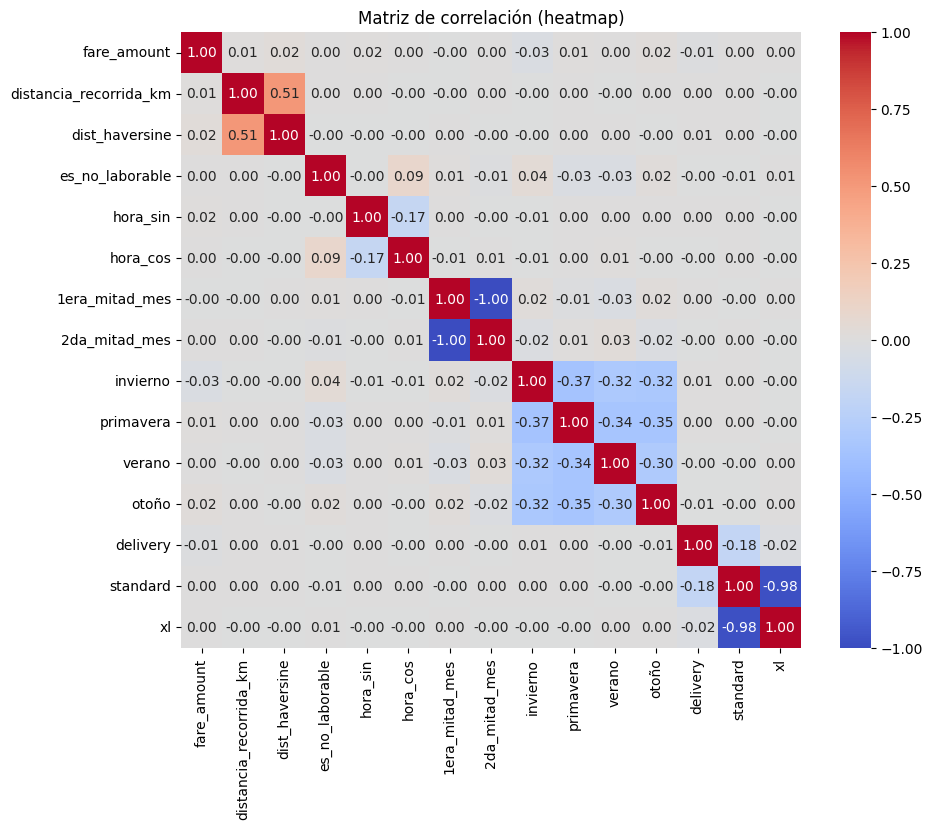

In [92]:
# Graficamos una matriz de correlación (heatmap) para visualizar las relaciones entre las variables numéricas del DataFrame.
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación (heatmap)')
plt.show()

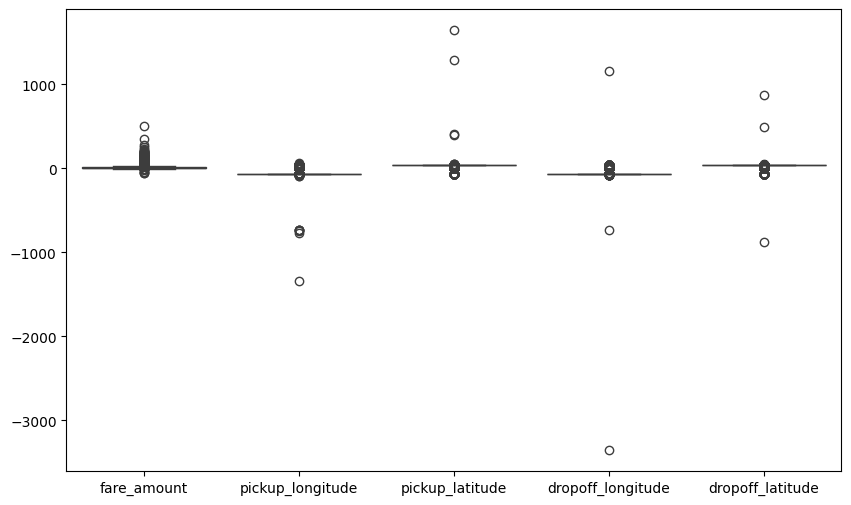

In [446]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df[['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']])
plt.show()

In [447]:
# División en train y test (80% - 20%)
y = df["fare_amount"]
X = df.drop(columns=["fare_amount"])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [448]:
# Valores fuera de rango en longitudes
longitudes_fuera_rango = df_train[
    (df_train['pickup_longitude'] < -180) | (df_train['pickup_longitude'] > 180) |
    (df_train['dropoff_longitude'] < -180) | (df_train['dropoff_longitude'] > 180)
]

# Valores fuera de rango en latitudes
latitudes_fuera_rango = df_train[
    (df_train['pickup_latitude'] < -90) | (df_train['pickup_latitude'] > 90) |
    (df_train['dropoff_latitude'] < -90) | (df_train['dropoff_latitude'] > 90)
]

print("Longitudes fuera de rango:")
print(longitudes_fuera_rango[['pickup_longitude', 'dropoff_longitude']])

print("\nLatitudes fuera de rango:")
print(latitudes_fuera_rango[['pickup_latitude', 'dropoff_latitude']])

Longitudes fuera de rango:
        pickup_longitude  dropoff_longitude
103745       -736.216667         -73.982377
91422          57.418457        1153.572603
199936       -736.400000         -73.982215
4949         -748.016667         -74.003570
161652       -735.433332         -74.006373
75851       -1340.648410       -3356.666300
48506        -735.200000         -73.980187

Latitudes fuera de rango:
       pickup_latitude  dropoff_latitude
61793       401.066667         40.754117
91422      1292.016128       -881.985513
56617       404.433332         40.769037
75851      1644.421482        872.697628


In [449]:
# Son errores de carga o registro, no representan ubicaciones reales y son ínfimos, por lo que se procede a eliminarlos
df_train = df_train[
    (df_train['pickup_longitude'] >= -180) & (df_train['pickup_longitude'] <= 180) &
    (df_train['dropoff_longitude'] >= -180) & (df_train['dropoff_longitude'] <= 180) &
    (df_train['pickup_latitude'] >= -90) & (df_train['pickup_latitude'] <= 90) &
    (df_train['dropoff_latitude'] >= -90) & (df_train['dropoff_latitude'] <= 90)
]

In [450]:
# Ver y contar registros donde pickup_longitude y pickup_latitude son iguales a dropoff_longitude y dropoff_latitude
mask = (df['pickup_longitude'] == df['dropoff_longitude']) & (df['pickup_latitude'] == df['dropoff_latitude'])
registros_iguales = df[mask]
print(f"Cantidad de registros con misma lat/lon de origen y destino: {registros_iguales.shape[0]}")
registros_iguales

Cantidad de registros con misma lat/lon de origen y destino: 5632


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_recorrida,distancia_recorrida_km,dist_haversine,...,2da_mitad_mes,hora_sin,hora_cos,invierno,primavera,verano,otoño,delivery,standard,xl
5,4.9,2011-02-12 02:27:09,-73.969019,40.755910,-73.969019,40.755910,1,0.0,0.0,0.0,...,0,0.500000,8.660254e-01,1,0,0,0,0,1,0
7,2.5,2012-12-11 13:52:00,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,...,0,-0.258819,-9.659258e-01,0,0,0,1,0,1,0
11,8.5,2011-05-23 22:15:00,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,...,1,-0.500000,8.660254e-01,0,1,0,0,0,1,0
48,56.8,2013-01-03 22:24:41,-73.993498,40.764686,-73.993498,40.764686,1,0.0,0.0,0.0,...,0,-0.500000,8.660254e-01,1,0,0,0,0,1,0
65,6.0,2014-05-05 19:27:00,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,...,0,-0.965926,2.588190e-01,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199880,6.5,2014-02-22 06:45:46,0.000000,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,...,1,1.000000,6.123234e-17,1,0,0,0,0,1,0
199883,12.5,2012-09-10 17:39:00,0.000000,0.000000,0.000000,0.000000,2,0.0,0.0,0.0,...,0,-0.965926,-2.588190e-01,0,0,1,0,0,1,0
199917,4.5,2013-06-24 22:17:43,-73.793768,40.656939,-73.793768,40.656939,1,0.0,0.0,0.0,...,1,-0.500000,8.660254e-01,0,0,1,0,0,1,0
199932,24.9,2011-03-22 13:59:00,-73.974618,40.756295,-73.974618,40.756295,5,0.0,0.0,0.0,...,1,-0.258819,-9.659258e-01,0,1,0,0,0,0,1


In [451]:
'''
# Imputar dist_haversine para registros donde pickup_longitude y dropoff_longitude coinciden, usando la media de los registros que NO coinciden en ambas longitudes y que tampoco sean nulos
def imputar_haversine_externo(row):
    if pd.isna(row['dist_haversine']):
        mask = (df['pickup_longitude'] == row['pickup_longitude']) & (df['dropoff_longitude'] == row['dropoff_longitude'])
        # Solo usar la media de los registros que NO coinciden en ambas longitudes y que NO sean nulos
        mean_val = df.loc[~mask & (~df['dist_haversine'].isna()), 'dist_haversine'].mean()
        return mean_val
    else:
        return row['dist_haversine']

df['dist_haversine'] = df.apply(imputar_haversine_externo, axis=1)
'''

"\n# Imputar dist_haversine para registros donde pickup_longitude y dropoff_longitude coinciden, usando la media de los registros que NO coinciden en ambas longitudes y que tampoco sean nulos\ndef imputar_haversine_externo(row):\n    if pd.isna(row['dist_haversine']):\n        mask = (df['pickup_longitude'] == row['pickup_longitude']) & (df['dropoff_longitude'] == row['dropoff_longitude'])\n        # Solo usar la media de los registros que NO coinciden en ambas longitudes y que NO sean nulos\n        mean_val = df.loc[~mask & (~df['dist_haversine'].isna()), 'dist_haversine'].mean()\n        return mean_val\n    else:\n        return row['dist_haversine']\n\ndf['dist_haversine'] = df.apply(imputar_haversine_externo, axis=1)\n"

In [452]:
'''
# Imputar dist_haversine usando regresión lineal para registros con pickup y dropoff iguales
mask_iguales = (df['pickup_longitude'] == df['dropoff_longitude']) & (df['pickup_latitude'] == df['dropoff_latitude'])
mask_validos = (~mask_iguales) & (~df['dist_haversine'].isna()) & (~df['fare_amount'].isna())
X_reg = df.loc[mask_validos, ['dist_haversine']]
y_reg = df.loc[mask_validos, 'fare_amount']
modelo = LinearRegression()
modelo.fit(X_reg, y_reg)
# Para los registros con pickup y dropoff iguales y dist_haversine nulo, predecir dist_haversine a partir de fare_amount
mask_imputar = mask_iguales & (df['dist_haversine'].isna()) & (~df['fare_amount'].isna())
# Invertir la regresión: dist_haversine = (fare_amount - intercept) / coef
intercept = modelo.intercept_
coef = modelo.coef_[0]
df.loc[mask_imputar, 'dist_haversine'] = (df.loc[mask_imputar, 'fare_amount'] - intercept) / coef
df.loc[mask_imputar, 'dist_haversine'] = df.loc[mask_imputar, 'dist_haversine'].clip(lower=0) # No permitir distancias negativas
df.loc[mask_imputar, 'dist_haversine']
'''

"\n# Imputar dist_haversine usando regresión lineal para registros con pickup y dropoff iguales\nmask_iguales = (df['pickup_longitude'] == df['dropoff_longitude']) & (df['pickup_latitude'] == df['dropoff_latitude'])\nmask_validos = (~mask_iguales) & (~df['dist_haversine'].isna()) & (~df['fare_amount'].isna())\nX_reg = df.loc[mask_validos, ['dist_haversine']]\ny_reg = df.loc[mask_validos, 'fare_amount']\nmodelo = LinearRegression()\nmodelo.fit(X_reg, y_reg)\n# Para los registros con pickup y dropoff iguales y dist_haversine nulo, predecir dist_haversine a partir de fare_amount\nmask_imputar = mask_iguales & (df['dist_haversine'].isna()) & (~df['fare_amount'].isna())\n# Invertir la regresión: dist_haversine = (fare_amount - intercept) / coef\nintercept = modelo.intercept_\ncoef = modelo.coef_[0]\ndf.loc[mask_imputar, 'dist_haversine'] = (df.loc[mask_imputar, 'fare_amount'] - intercept) / coef\ndf.loc[mask_imputar, 'dist_haversine'] = df.loc[mask_imputar, 'dist_haversine'].clip(lower=0) #

In [453]:
'''
# Visualizar los registros imputados con regresión lineal para dist_haversine
registros_imputados = df[mask_iguales & (~df['dist_haversine'].isna())]
print(f"Cantidad de registros imputados: {registros_imputados.shape[0]}")
registros_imputados[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'dist_haversine']]
'''

'\n# Visualizar los registros imputados con regresión lineal para dist_haversine\nregistros_imputados = df[mask_iguales & (~df[\'dist_haversine\'].isna())]\nprint(f"Cantidad de registros imputados: {registros_imputados.shape[0]}")\nregistros_imputados[[\'pickup_longitude\', \'pickup_latitude\', \'dropoff_longitude\', \'dropoff_latitude\', \'fare_amount\', \'dist_haversine\']]\n'

In [454]:
# Eliminar filas donde passenger_count sea igual a 208
df_train = df_train[df_train['passenger_count'] != 208]

In [455]:
# PARA ENCONTRAR VALORES NEGATIVOS QUE NO CORRESPONDEN Y MINIMOS ABSURDOS
df_train['fare_amount'].value_counts().sort_index().head(20)

fare_amount
-52.00       2
-50.50       1
-49.57       1
-23.70       1
-10.90       1
-7.30        1
-5.00        1
-3.50        3
-3.30        1
-3.00        2
 0.00        5
 0.01        2
 2.50      662
 2.60        1
 2.90      391
 3.00      287
 3.25        1
 3.30     1102
 3.40        9
 3.50      874
Name: count, dtype: int64

Eliminamos los siguientes datos considerados erroneos:
- Fare 0
- Fare 0.01 y 0.11 tambien eliminar ya que no se corresponden a la distancia recorrida
- Todos los fare negativos tambien se eliminan

In [456]:
# Eliminar filas donde fare_amount sea menor o igual a 0.11
df_train = df_train[df_train['fare_amount'] > 0.11]

In [457]:
# Cambiar todos los valores de dist_haversine menores a 0.1 por NaN en df_train
df_train.loc[df_train['dist_haversine'] < 0.1, 'dist_haversine'] = np.nan

In [458]:
# Imputación de dist_haversine en df_train usando regresión lineal invertida
# 1. Filtrar filas con dist_haversine y fare_amount válidos en df_train
dftrain_valid = df_train[~df_train['dist_haversine'].isna()]

# 2. Entrenar modelo de regresión lineal: fare_amount ~ dist_haversine
X = dftrain_valid[['fare_amount']]
y = dftrain_valid['dist_haversine']

model = LinearRegression()
model.fit(X, y)

# 3. Predecir dist_haversine para los viajes con dist_haversine NaN y fare_amount válido en df_train
mask_missing = df_train['dist_haversine'].isna()
intercept = model.intercept_
coef = model.coef_[0]
df_train.loc[mask_missing, 'dist_haversine'] = (df_train.loc[mask_missing, 'fare_amount'] - intercept) / coef
df_train.loc[mask_missing, 'dist_haversine'] = df_train.loc[mask_missing, 'dist_haversine'].clip(lower=0)

print(f"Cantidad de valores imputados en df_train: {mask_missing.sum()}")

Cantidad de valores imputados en df_train: 5397


In [459]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159968 entries, 153248 to 121958
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   fare_amount             159968 non-null  float64       
 1   pickup_datetime         159968 non-null  datetime64[ns]
 2   pickup_longitude        159968 non-null  float64       
 3   pickup_latitude         159968 non-null  float64       
 4   dropoff_longitude       159968 non-null  float64       
 5   dropoff_latitude        159968 non-null  float64       
 6   passenger_count         159968 non-null  int64         
 7   distancia_recorrida     159968 non-null  float64       
 8   distancia_recorrida_km  159968 non-null  float64       
 9   dist_haversine          159968 non-null  float64       
 10  es_no_laborable         159968 non-null  int64         
 11  hora_del_dia            159968 non-null  int32         
 12  1era_mitad_mes          159968

In [460]:
# Eliminar columnas que no aportan al análisis
df_train = df_train.drop(columns=['distancia_recorrida',
    'pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude',
    'passenger_count', 'hora_del_dia', 'pickup_datetime'
])

# Eliminar columnas que no aportan al análisis en test
df_test = df_test.drop(columns=['distancia_recorrida',
    'pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude',
    'passenger_count', 'hora_del_dia', 'pickup_datetime'
])

In [461]:
df_train.sort_values('distancia_recorrida_km').head()

,fare_amount,distancia_recorrida_km,dist_haversine,es_no_laborable,1era_mitad_mes,2da_mitad_mes,hora_sin,hora_cos,invierno,primavera,verano,otoño,delivery,standard,xl
123158,18.0,0.0,8.527177,0,1,0,0.866025,-0.500000,0,0,0,1,0,1,0
172011,4.9,0.0,0.000000,0,0,1,0.965926,-0.258819,1,0,0,0,0,1,0
17157,11.7,0.0,2.501126,1,1,0,0.707107,0.707107,1,0,0,0,0,1,0
168768,20.0,0.0,10.440209,0,1,0,0.707107,0.707107,0,1,0,0,0,1,0
34075,12.0,0.0,2.788081,1,0,1,0.707107,-0.707107,1,0,0,0,0,1,0


In [462]:
# Separar variables predictoras y target en train y test
X_train = df_train.drop(columns=['fare_amount'])
y_train = df_train['fare_amount']

X_test = df_test.drop(columns=['fare_amount'])
y_test = df_test['fare_amount']

In [463]:
X_train.sort_values('distancia_recorrida_km').head()

,distancia_recorrida_km,dist_haversine,es_no_laborable,1era_mitad_mes,2da_mitad_mes,hora_sin,hora_cos,invierno,primavera,verano,otoño,delivery,standard,xl
123158,0.0,8.527177,0,1,0,0.866025,-0.500000,0,0,0,1,0,1,0
172011,0.0,0.000000,0,0,1,0.965926,-0.258819,1,0,0,0,0,1,0
17157,0.0,2.501126,1,1,0,0.707107,0.707107,1,0,0,0,0,1,0
168768,0.0,10.440209,0,1,0,0.707107,0.707107,0,1,0,0,0,1,0
34075,0.0,2.788081,1,0,1,0.707107,-0.707107,1,0,0,0,0,1,0


In [464]:

# Escalar solo 'distancia_recorrida_km' y 'dist_haversine'
cols_to_scale = ['distancia_recorrida_km', 'dist_haversine']

scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Modelos con todas las variables además de la principal
X_km_train = X_train.drop(columns=["dist_haversine"])
X_km_test = X_test.drop(columns=["dist_haversine"])

X_hav_train = X_train.drop(columns=["distancia_recorrida_km"])
X_hav_test = X_test.drop(columns=["distancia_recorrida_km"])

# Modelo 1: Regresión lineal con distancia_recorrida_km
modelo_km = LinearRegression()
modelo_km.fit(X_km_train, y_train)
y_pred_km = modelo_km.predict(X_km_test)

# Modelo 2: Regresión lineal con dist_haversine
modelo_hav = LinearRegression()
modelo_hav.fit(X_hav_train, y_train)
y_pred_hav = modelo_hav.predict(X_hav_test)

# Evaluación simple de los modelos
print("Modelo con distancia_recorrida_km")
print("MSE:", mean_squared_error(y_test, y_pred_km))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_km)))
print("MAE:", mean_absolute_error(y_test, y_pred_km))
print("MAPE:", np.mean(np.abs((y_test - y_pred_km) / y_test)) * 100)
print("R2:", r2_score(y_test, y_pred_km))

print("\nModelo con dist_haversine")
print("MSE:", mean_squared_error(y_test, y_pred_hav))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_hav)))
print("MAE:", mean_absolute_error(y_test, y_pred_hav))
print("MAPE:", np.mean(np.abs((y_test - y_pred_hav) / y_test)) * 100)
print("R2:", r2_score(y_test, y_pred_hav))

Modelo con distancia_recorrida_km
MSE: 106.21193466799986
RMSE: 10.305917458819465
MAE: 6.101185892748052
MAPE: 66.2102537655542
R2: 0.0010259616709086261

Modelo con dist_haversine
MSE: 106.14557928998589
RMSE: 10.302697670512606
MAE: 6.099285890287477
MAPE: 66.19143936512431
R2: 0.0016500657336644409


In [465]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

In [466]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

In [467]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

NOS QUEDAMOS CON HAVERSINE PORQUE AJUSTA MEJOR

In [468]:
# Ejemplo de reshape para cada conjunto de datos, útil si solo usás una variable predictora (columna)
y_train_rs = y_train.values.reshape(-1, 1)
y_test_rs = y_test.values.reshape(-1, 1)

X_hav_train
X_hav_test

,dist_haversine,es_no_laborable,1era_mitad_mes,2da_mitad_mes,hora_sin,hora_cos,invierno,primavera,verano,otoño,delivery,standard,xl
119737,-0.051730,0,1,0,-0.258819,9.659258e-01,0,0,0,1,0,1,0
72272,-0.054202,1,1,0,-0.707107,7.071068e-01,0,0,1,0,0,0,1
158154,-0.048743,0,0,1,-1.000000,-1.836970e-16,0,0,1,0,0,0,1
65426,-0.032181,0,1,0,-0.866025,5.000000e-01,0,0,0,1,0,1,0
30074,-0.052117,0,0,1,0.866025,-5.000000e-01,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4174,-0.051122,1,0,1,0.000000,1.000000e+00,0,0,1,0,0,1,0
91537,-0.041428,0,0,1,0.866025,-5.000000e-01,0,0,0,1,0,1,0
156449,-0.052532,0,0,1,0.258819,-9.659258e-01,0,0,1,0,0,1,0
184376,-0.051011,0,1,0,-0.258819,-9.659258e-01,0,0,1,0,0,1,0


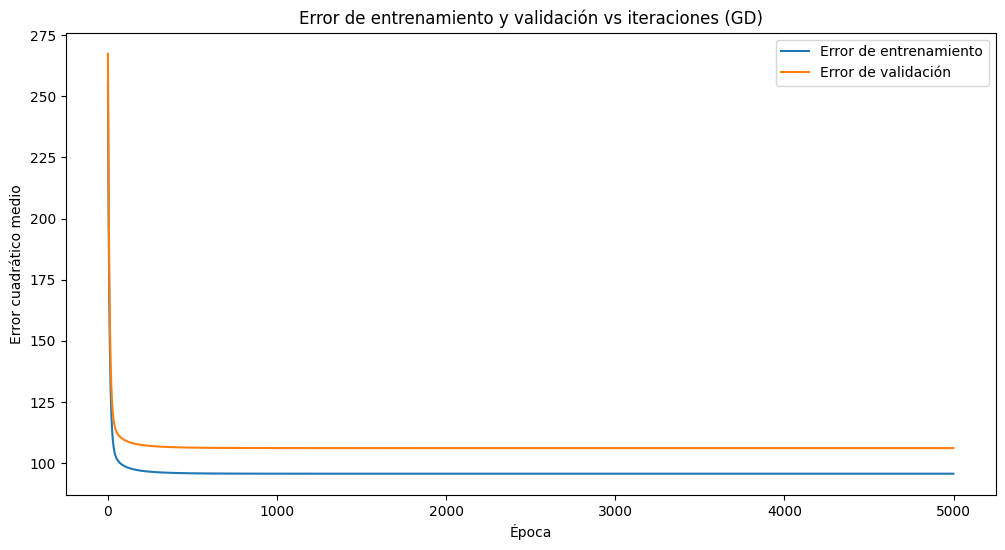

array([[ 5.46566683],
       [ 0.26311497],
       [ 0.05081996],
       [ 2.53485361],
       [ 2.61040471],
       [ 0.23142494],
       [ 0.04608795],
       [ 1.00471865],
       [ 1.57202631],
       [ 1.49113533],
       [ 1.82360646],
       [-1.11114906],
       [ 1.88003596],
       [ 1.94330244]])

In [ ]:
gradient_descent(X_hav_train, y_train_rs, X_hav_test, y_test_rs, lr=0.01, epochs=5000)

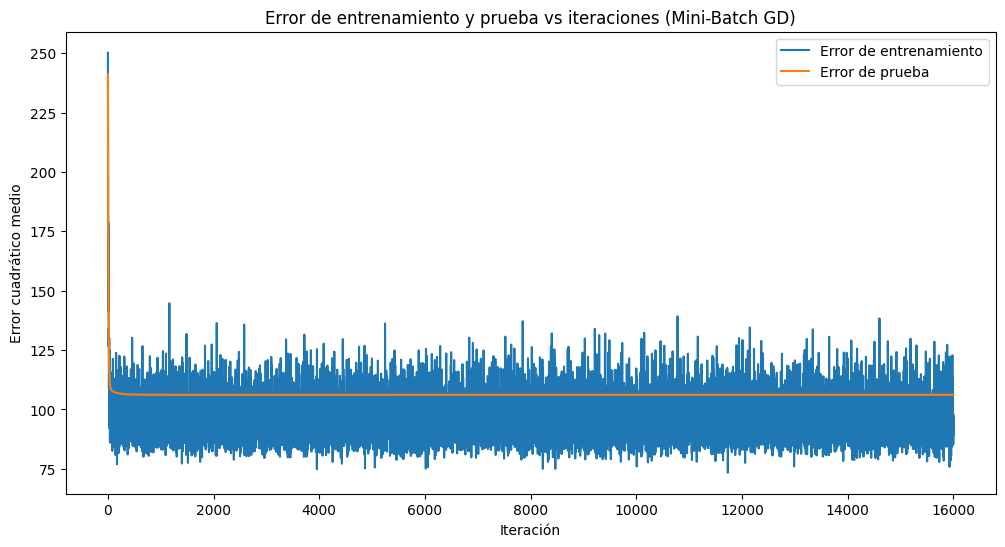

array([[4.9703369 ],
       [0.25588742],
       [0.04749697],
       [2.25727234],
       [2.33084119],
       [0.23178988],
       [0.04838224],
       [1.21749728],
       [1.78526553],
       [1.70487067],
       [2.03930838],
       [0.76211152],
       [2.42778229],
       [2.47559635]])

In [ ]:
mini_batch_gradient_descent(X_hav_train, y_train_rs, X_hav_test, y_test_rs, lr=0.01, epochs=500, batch_size=5000)

In [ ]:

def stochastic_gradient_descent_avg(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, avg_window=1000):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)
            W = W - (lr * gradient)

    # Promediar errores cada avg_window iteraciones
    def moving_average(arr, window):
        arr = np.array(arr).flatten()
        return [np.mean(arr[i:i+window]) for i in range(0, len(arr), window)]

    train_errors_avg = moving_average(train_errors, avg_window)
    test_errors_avg = moving_average(test_errors, avg_window)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors_avg, label='Error de entrenamiento (promediado)')
    plt.plot(test_errors_avg, label='Error de prueba (promediado)')
    plt.xlabel('Bloque de iteraciones')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba promediado vs iteraciones (SGD)')
    plt.show()

    return W

# Usar la función promediada:
stochastic_gradient_descent_avg(X_hav_train, y_train_rs, X_hav_test, y_test_rs, lr=0.0005, epochs=5, avg_window=1000)

KeyboardInterrupt: 

c:\Users\FZ\Desktop\TUIA_4TO\AA1\venvAA1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


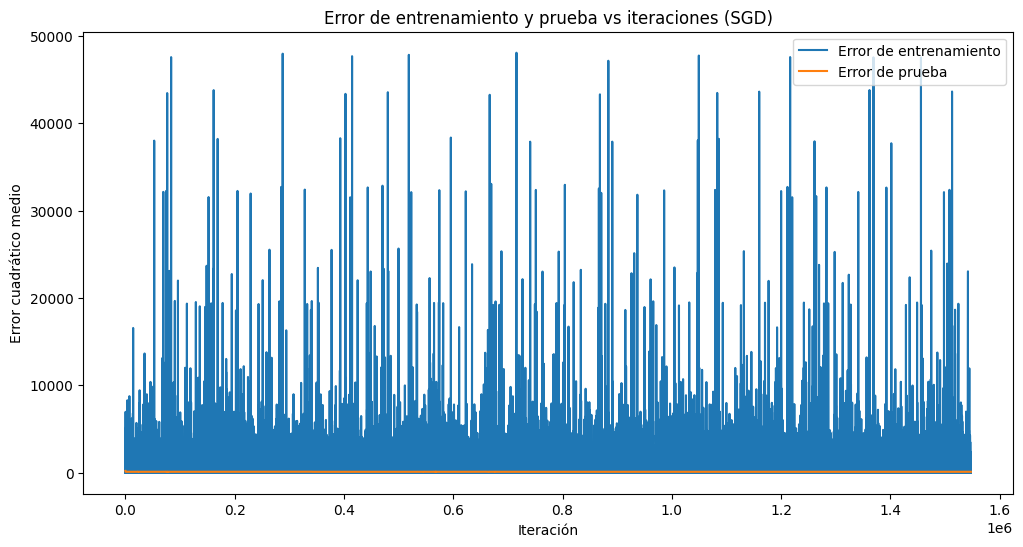

array([[ 5.52226616],
       [-0.31856647],
       [ 0.57684433],
       [ 4.13911715],
       [ 3.70948093],
       [ 0.63031402],
       [ 0.73973179],
       [ 0.0452189 ],
       [ 1.61954083],
       [ 2.09775714]])

In [ ]:
stochastic_gradient_descent(X_hav_train, y_train_rs, X_hav_test, y_test_rs, lr=0.001, epochs=10)

In [469]:
# Usamos las variables escaladas y todas las features
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_hav_train, y_train)

print("Mejor alpha encontrado:", lasso_cv.alpha_)
print("Coeficientes:", lasso_cv.coef_)

# Predicción y evaluación en test
y_pred_lasso = lasso_cv.predict(X_hav_test)
print("\nResultados LassoCV:")
print("MSE:", mean_squared_error(y_test, y_pred_lasso))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("MAE:", mean_absolute_error(y_test, y_pred_lasso))
print("MAPE:", np.mean(np.abs((y_test - y_pred_lasso) / y_test)) * 100)
print("R2:", r2_score(y_test, y_pred_lasso))

Mejor alpha encontrado: 0.0002618707701849041
Coeficientes: [ 0.26249128  0.04870016 -0.07465942  0.          0.23122074  0.04639929
 -0.56585294  0.         -0.0777013   0.25299413 -1.7521507  -0.
  0.04370887]

Resultados LassoCV:
MSE: 106.14581732017989
RMSE: 10.302709222344378
MAE: 6.099280546083135
MAPE: 66.1917661985394
R2: 0.0016478269458588546


# Ingeniería de Variables para Análisis de Viajes en Taxi

## 1. Creación de Variables Derivadas

### Distancia entre Origen y Destino
- **Distancia Euclidiana**: Calculada en grados entre dos puntos. Es rápida de calcular, aunque no representa la ruta real sobre la superficie terrestre.
- **Distancia Haversine**: Calculada en kilómetros o metros, es una medida más precisa para coordenadas geográficas, considerando la curvatura de la Tierra.
- **Distancia Absoluta (Manhattan)**: Suma de las diferencias absolutas de latitud y longitud, útil para aproximar trayectos en ciudades con calles en cuadrícula (como Manhattan).

### Características Temporales del Viaje
Extraídas a partir de `pickup_datetime`:
- **Hora del día** (`0-23`): Permite analizar si el horario influye en la tarifa.
- **Día de la semana** (`Lunes` a `Domingo`): Útil para detectar diferencias entre días laborables y fines de semana.
- **Semana del año**: Puede ayudar a detectar patrones estacionales o eventos especiales.
- **Mes** o **Estación del año**: Para analizar estacionalidad en la demanda.
- **¿Es hora pico?**: Variable booleana según franjas horarias (ej.: 7-9 AM y 5-7 PM).
- **¿Es fin de semana?**: Variable booleana para diferenciar sábados y domingos.

### Duración del Viaje
- Si se dispone del tiempo de llegada, calcular la duración real.
- Si no, **estimar la duración** utilizando la distancia y una velocidad promedio (ejemplo: duración = distancia / velocidad promedio).

### Variables de Interacción
- **Distancia × Cantidad de Pasajeros**: Para observar si viajes largos con más pasajeros modifican la tarifa por persona.
- **Hora × Día de la semana**: Permite captar efectos combinados entre horario y tipo de día.

---

## 2. Identificación y Tratamiento de Datos Problemáticos

### Valores Atípicos (Outliers)
- Detectar valores extremos en variables como distancia, tarifa o cantidad de pasajeros.
- Analizar si tienen sentido físico (ej.: viajes con distancia cero pero tarifa alta).

### Datos Faltantes (Missing Values)
- Identificar columnas con valores faltantes.
- Decidir el tratamiento adecuado: imputación, eliminación, o reemplazo según el caso.

---

### Notas
- Las variables temporales pueden codificarse como **cualitativas ordinales** para ciertos modelos (ej.: día de la semana, semana del año).
- La ingeniería de variables adecuada puede mejorar significativamente el rendimiento de los modelos de regresión y la interpretación de los resultados.

In [ ]:
# 4. Análisis y tratamiento de datos faltantes
# Comentario: Se identifican valores faltantes y se decide cómo tratarlos (eliminación, imputación, etc.).
# - df.isnull().sum()
# - Justificación de la decisión tomada

In [ ]:
# 5. Análisis y tratamiento de datos atípicos (outliers)
# Comentario: Se detectan y tratan valores atípicos en las variables numéricas.
# - Visualización con boxplots
# - Decisión sobre el tratamiento (eliminación, ajuste, etc.)

In [ ]:
# 6. Visualización de datos
# Comentario: Se grafican histogramas y scatterplots para analizar la distribución y relaciones entre variables.
# - Histograma de cada variable
# - Scatterplots entre variables relevantes
# - Diagramas de caja

In [ ]:
# 7. Codificación de variables categóricas (si corresponde)
# Comentario: Se codifican variables categóricas para su uso en modelos (OneHotEncoder, LabelEncoder, etc.).
# - Ejemplo: df['var'] = ...

In [ ]:
# 8. Matriz de correlación
# Comentario: Se calcula la matriz de correlación para analizar dependencias entre variables.
# - sns.heatmap(df.corr(), annot=True)

In [ ]:
# 9. Estandarización o escalado de datos
# Comentario: Se aplican técnicas de escalado para mejorar el desempeño de los modelos.
# - StandardScaler, MinMaxScaler, etc.

In [ ]:
X_train.describe()

In [ ]:
# 11. Implementación de modelos de regresión
# 11.a. Regresión lineal múltiple (LinearRegression)
# Comentario: Se ajusta el modelo base de regresión lineal.

In [ ]:
# 11.b. Métodos de gradiente descendente (SGDRegressor, otros)
# Comentario: Se prueban diferentes variantes de gradiente descendente.
# - Se grafican errores vs iteraciones (loss vs epochs)

In [ ]:
# 12. Evaluación de modelos: métricas de regresión
# Comentario: Se calculan las métricas elegidas para train y test (R2, MSE, RMSE, MAE, MAPE).
# - Justificación de las métricas utilizadas

In [ ]:
# 13. Gráficos de residuos
# Comentario: Se grafican los residuos para analizar el ajuste de los modelos.


In [ ]:
# 14. Análisis de fitting y conclusiones intermedias
# Comentario: Se analiza el fitting del modelo y se discuten los efectos de la regularización y gradiente descendente.


In [ ]:
# 15. Optimización y comparación de hiperparámetros
# Comentario: Se varían los hiperparámetros y se observa el efecto en el desempeño del modelo.
# - GridSearchCV, RandomizedSearchCV, o análisis manual


In [ ]:
# 16. Comparación de modelos
# Comentario: Se compara el desempeño de los distintos modelos y se selecciona el mejor.
# - Justificación de la métrica de comparación